In [1]:
""" IMPORT MODULES """
import pandas as pd
import tensorflow as tf
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from keras import layers

## First Look

In [2]:
df_train_org = pd.read_excel(r"D:\dataset\DA_titanic_train.xlsx")
df_test_org = pd.read_excel(r"D:\dataset\DA_titanic_test.xlsx")

In [3]:
df_train_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  624 non-null    int64  
 1   Survived     624 non-null    int64  
 2   Pclass       624 non-null    int64  
 3   Name         624 non-null    object 
 4   Sex          624 non-null    object 
 5   Age          494 non-null    float64
 6   SibSp        624 non-null    int64  
 7   Parch        624 non-null    int64  
 8   Ticket       624 non-null    object 
 9   Fare         624 non-null    float64
 10  Cabin        128 non-null    object 
 11  Embarked     623 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 58.6+ KB


NAN values in Age, Cabin

In [4]:
df_train_org.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,624.000000,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,29.658745,0.519231,0.354167,30.523470
std,257.314092,0.486511,0.822684,14.770773,1.071871,0.775559,48.186064
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,460.500000,0.000000,3.000000,28.000000,0.000000,0.000000,13.931250
75%,683.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Cleaning Data

In [5]:
def clean_data(data, removable_cols):
    """Removing columns"""
    new_data = data.copy()
    for col in removable_cols:
        new_data.pop(col)
    
    return new_data

def replace_nan_with_median(data, columns):
    """Replcaing NaN values with median values"""
    for col in columns:
        data[col].fillna(data[col].median(), inplace=True)

In [6]:
# Cleaning data
removable_tables = ["PassengerId", "Name", "Ticket", "Cabin"]
df_train = clean_data(df_train_org, removable_tables)
df_test = clean_data(df_test_org, removable_tables)

In [7]:
# New table names
table_names = ["surv", "pclass", "male", "age", "sibsp", "parch", "fare", "emb"]
for i, name in enumerate(df_train):
    df_train = df_train.rename({name:table_names[i]}, axis="columns")
    df_test = df_test.rename({name:table_names[i]}, axis="columns")

In [8]:
# Replace NaN values
replace_nan_with_median(df_train, ["age"])
replace_nan_with_median(df_test, ["age", "fare"])

## Feature visualization 

### Plot Passenger Sex

In [9]:
def plot_mean(f1, f2, mean, title: str):
  pd.concat([f1, f2], axis=1).groupby(f1)[mean].mean().plot(kind="bar", title=title, rot=0)

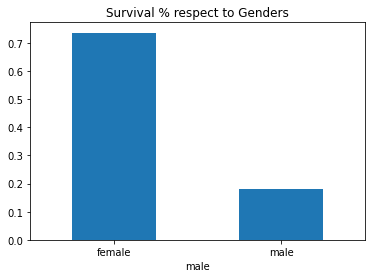

In [10]:
plot_mean(df_train.male, df_train.surv, "surv", "Survival % respect to Genders")

### Plot Passenger Age

<AxesSubplot:title={'center':'Passenger Age'}, ylabel='Frequency'>

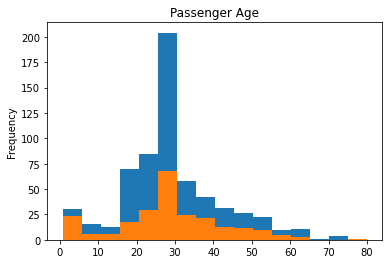

In [11]:
df_train.age.plot(kind="hist", bins=16, title="Passenger Age", xlabel="Age in years", rot=0)
df_train.age[df_train.surv == 1].plot(kind="hist", bins=16, title="Passenger Age", xlabel="Age in years", rot=0) 

<AxesSubplot:>

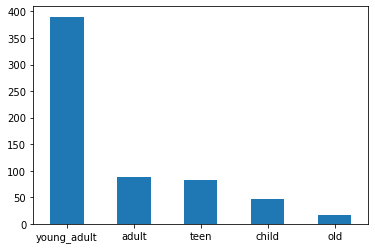

In [12]:
# Create age bins
age_bins = [0, 10, 20, 40, 60, 100]
age_cat = ["child", "teen", "young_adult", "adult", "old" ]

df_train["age_bins"] = pd.cut(df_train.age, bins=age_bins, labels=age_cat)
df_train.age_bins.value_counts().plot(kind="bar", rot=0)

df_test["age_bins"] = pd.cut(df_test.age, bins=age_bins, labels=age_cat)
df_test.age_bins.value_counts().plot(kind="bar", rot=0)

In [13]:
# One hot encode age
one_hot_age = pd.get_dummies(df_train.age_bins)
one_hot_age = one_hot_age.rename({1:"child", 2:"teen", 3:"young_adult", 4:"adult", 5:"old"}, axis="columns")
df_train = pd.concat([df_train, one_hot_age], axis=1)

one_hot_age = pd.get_dummies(df_test.age_bins)
one_hot_age = one_hot_age.rename({1:"child", 2:"teen", 3:"young_adult", 4:"adult", 5:"old"}, axis="columns")
df_test = pd.concat([df_test, one_hot_age], axis=1)

### Plot number of siblings and/or spouse

<AxesSubplot:title={'center':'Siblings and/or Spouse'}, xlabel='Sibling/Spouse count'>

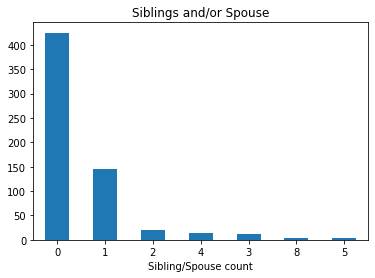

In [14]:
df_train.sibsp.value_counts().plot(kind="bar", title="Siblings and/or Spouse", xlabel="Sibling/Spouse count", rot=0)

In [15]:
# Survival percentage
for i, x in enumerate(df_train.sibsp.unique()):
    print(x, df_train.surv[df_train.sibsp == x].mean())

1 0.541095890410959
0 0.3388235294117647
4 0.14285714285714285
3 0.2727272727272727
2 0.5238095238095238
5 0.0
8 0.0


In [16]:
# Clipping feature values at 3
df_train.sibsp = df_train.sibsp.clip(0,3)
df_test.sibsp = df_train.sibsp.clip(0,3)

In [17]:
# One hot encode siblings and spouses
one_hot_sibsp = pd.get_dummies(df_train.sibsp)
one_hot_sibsp = one_hot_sibsp.rename({0:"0sibsp", 1:"1sibsp", 2:"2sibsp", 3:"3_sibsp"}, axis="columns")
df_train = pd.concat([df_train, one_hot_sibsp], axis=1)

one_hot_sibsp = pd.get_dummies(df_test.sibsp)
one_hot_sibsp = one_hot_sibsp.rename({0:"0sibsp", 1:"1sibsp", 2:"2sibsp", 3:"3_sibsp"}, axis="columns")
df_test = pd.concat([df_test, one_hot_sibsp], axis=1)

### Plot number of parents/children

<AxesSubplot:title={'center':'Numver of Parents or Children'}, xlabel='Parent/Child count'>

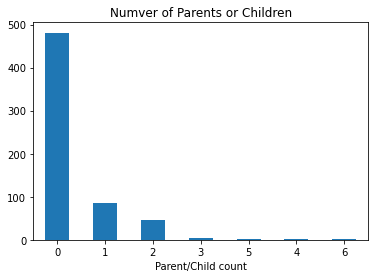

In [18]:
df_train.parch.value_counts().plot(kind="bar", title="Numver of Parents or Children", xlabel="Parent/Child count", rot=0)

In [19]:
# Surival percentage
for i, x in enumerate(df_train.parch.unique()):
    print(x, df_train.surv[df_train.parch == x].mean())

0 0.34303534303534305
1 0.5465116279069767
5 0.3333333333333333
2 0.48936170212765956
3 0.75
4 0.0
6 0.0


In [20]:
# Clipping parent/children values at 3
df_train.parch = df_train.parch.clip(0,3)
df_test.parch = df_train.parch.clip(0,3)
# parch_bins = [0, 1, 3]
# parch_cat = ["0parch" ,"1-2parch", "3+parch"]

# df_train["parch_bins"] = pd.cut(df_train.parch, bins=parch_bins, labels=parch_cat)
# df_train.parch_bins.value_counts().plot(kind="bar", rot=0)

# df_test["parch_bins"] = pd.cut(df_test.age, bins=parch_bins, labels=parch_cat)
# df_test.parch_bins.value_counts().plot(kind="bar", rot=0)

In [21]:
# One hot encode parent/children
one_hot_parch = pd.get_dummies(df_train.parch)
one_hot_parch = one_hot_parch.rename({0:"0parch", 1:"1parch", 2:"2parch", 3:"3parch"}, axis="columns")
df_train = pd.concat([df_train, one_hot_parch], axis=1)

one_hot_parch = pd.get_dummies(df_test.parch)
one_hot_parch = one_hot_parch.rename({0:"0parch", 1:"1parch", 2:"2parch", 3:"3parch"}, axis="columns")
df_test = pd.concat([df_test, one_hot_parch], axis=1)

### Plot fare

<AxesSubplot:ylabel='Frequency'>

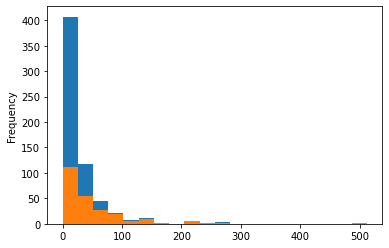

In [22]:
df_train.fare.plot(kind="hist", bins=20)
df_train.fare[df_train.surv == 1].plot(kind="hist", bins=20)

CLIPPING FEATURE VALUES AT 150 AND NORM

In [23]:
# Clipping at 100, than normalize
df_train.fare = df_train.fare.clip(0, 100)
df_train.fare = df_train.fare.round() / 100

df_test.fare = df_test.fare.clip(0, 100)
df_test.fare = df_test.fare.round() / 100

<AxesSubplot:ylabel='Frequency'>

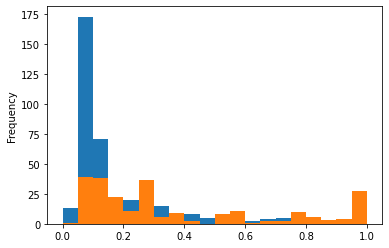

In [24]:
df_train.fare[df_train.surv == 0].plot(kind="hist", bins=20)
df_train.fare[df_train.surv == 1].plot(kind="hist", bins=20)

### Plot passanger class

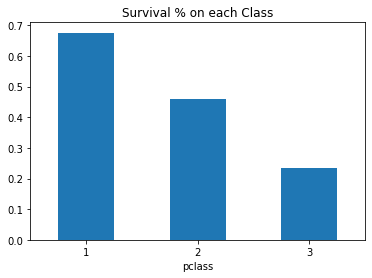

In [25]:
plot_mean(df_train.pclass, df_train.surv, "surv", "Survival % on each Class")

In [26]:
# One hot encode Passenger Class
# Train
one_hot_pclass = pd.get_dummies(df_train.pclass)
one_hot_pclass = one_hot_pclass.rename({1:"pclass1", 2:"pclass2", 3:"pclass3"}, axis="columns")
df_train = pd.concat([df_train, one_hot_pclass], axis=1)

# Test
one_hot_pclass_t = pd.get_dummies(df_test.pclass)
one_hot_pclass_t = one_hot_pclass_t.rename({1:"pclass1", 2:"pclass2", 3:"pclass3"}, axis="columns")
df_test = pd.concat([df_test, one_hot_pclass_t], axis=1)

In [27]:
# Converting categorical data to numerical
df_train = df_train.replace(['male', 'female'], [0,1])
df_test = df_test.replace(['male', 'female'], [0,1])

### Prep the data for train/test

In [28]:
not_needed_tables = ["pclass", "age", "sibsp", "parch", "emb", "age_bins"]

train_labels = df_train.pop("surv")

for name in not_needed_tables:
    df_train.pop(name)
    df_test.pop(name)

In [29]:
feature_column = [tf.feature_column.numeric_column(f) for f in df_train]
feature_layer = tf.keras.layers.DenseFeatures(feature_column)

train_data = {name:np.array(value) for name, value in df_train.items()}
train_labels = df_train_org.Survived

# Train

In [30]:
def create_model(my_learning_rate, feature_layer):
    """Create and compile the model"""
    model = tf.keras.models.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=["accuracy", tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, features, label, epochs, batch_size):
    """Train the model"""

    # store the information
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

    # store the information for each epoch
    epochs = history.epoch

    # print the info out
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse   

In [31]:
lr = 0.01
epochs = 50
batch_size = 10

# Create the models architecture
titanic_model = create_model(lr, feature_layer)
epochs, rmse = train_model(titanic_model, train_data, train_labels, epochs, batch_size)

Epoch 1/50
63/63 [==============================] - 0s 1ms/step - loss: 0.2992 - accuracy: 0.7276 - root_mean_squared_error: 0.5470
Epoch 2/50
63/63 [==============================] - 0s 1ms/step - loss: 0.2248 - accuracy: 0.7660 - root_mean_squared_error: 0.4741
Epoch 3/50
63/63 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.7740 - root_mean_squared_error: 0.4496
Epoch 4/50
63/63 [==============================] - 0s 1ms/step - loss: 0.1864 - accuracy: 0.7724 - root_mean_squared_error: 0.4318
Epoch 5/50
63/63 [==============================] - 0s 1ms/step - loss: 0.1748 - accuracy: 0.7772 - root_mean_squared_error: 0.4181
Epoch 6/50
63/63 [==============================] - 0s 1ms/step - loss: 0.1660 - accuracy: 0.7869 - root_mean_squared_error: 0.4074
Epoch 7/50
63/63 [==============================] - 0s 1ms/step - loss: 0.1600 - accuracy: 0.7917 - root_mean_squared_error: 0.4000
Epoch 8/50
63/63 [==============================] - 0s 1ms/step - loss: 0.15

# NON-LINEAR SOLUTION

In [32]:
df_to_array_buffer = df_train.copy()
train_labels = df_train_org.Survived
data_array = df_to_array_buffer.to_numpy()
print(data_array.shape)


(624, 18)


In [33]:
input_size = data_array.shape[1]
model = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(input_size,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.975), loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                608       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,850
Trainable params: 2,850
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x=data_array, y=train_labels, batch_size=10, epochs=50, validation_split=0.2)

Epoch 1/50
50/50 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6092 - val_loss: 0.6305 - val_accuracy: 0.6480
Epoch 2/50
50/50 [==============================] - 0s 1ms/step - loss: 0.6136 - accuracy: 0.6273 - val_loss: 0.5526 - val_accuracy: 0.7360
Epoch 3/50
50/50 [==============================] - 0s 1ms/step - loss: 0.5538 - accuracy: 0.7375 - val_loss: 0.5008 - val_accuracy: 0.8160
Epoch 4/50
50/50 [==============================] - 0s 1ms/step - loss: 0.5022 - accuracy: 0.7615 - val_loss: 0.4433 - val_accuracy: 0.8000
Epoch 5/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4727 - accuracy: 0.7675 - val_loss: 0.4172 - val_accuracy: 0.8080
Epoch 6/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4546 - accuracy: 0.7856 - val_loss: 0.4029 - val_accuracy: 0.8080
Epoch 7/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4427 - accuracy: 0.7936 - val_loss: 0.3861 - val_accuracy: 0.8240
Epoch 8/50
50/50 [==

## Make predictions

In [35]:
df_pred = df_test.copy()
test_data = df_pred.to_numpy()
result = model.predict(test_data)

In [36]:
# Format the output
data = []
for i, r in enumerate(result):
    surv = 0
    if r[0] < r[1]:
        surv = 1
    id = df_test_org.PassengerId.loc[i]
    data.append([id, surv])

In [37]:
result_df = pd.DataFrame(data)
result_df = result_df.rename({0:"PassengerId", 1:"Survived"}, axis="columns")

In [38]:
# result_df.to_csv("titanic_results.csv", index=False)
result_df

,PassengerId,Survived
0,4,1
1,6,0
2,7,0
3,8,1
4,9,1
...,...,...
262,880,1
263,882,0
264,886,1
265,887,0
